In [ ]:
# !jupyter nbconvert --to script pipeline_1.ipynb

In [1]:
import os
import matplotlib.pylab as plt
from glob import glob
import numpy as np

# READ IMAGES AND MASKS

In [2]:
PATH = os.path.abspath('data')

SOURCE_IMAGES = [os.path.join(PATH, "images/ds1"), os.path.join(PATH, "images/ds1/albumentated")]

images = []
labels = []

for si in SOURCE_IMAGES:
    images.extend(glob(os.path.join(si, "*.jpg")))
    labels.extend(glob(os.path.join(si.replace("images","labels"), "*.png")))

In [3]:
images.sort()
labels.sort()

In [4]:
print(np.size(images))
print(np.size(labels))

143
143


In [5]:
x = [] # images
y = [] # labels

for img in images:
    full_size_image = plt.imread(img)
    x.append(full_size_image)

for lbl in labels:
    full_size_label = plt.imread(lbl,0)
    y.append(full_size_label)
    
del(images, labels, full_size_image, full_size_label)

In [6]:
x = np.asarray(x[:10])
y = np.asarray(y[:10])

In [7]:
print(y.min())
print(y.max())
print(x.shape)
print(y.shape)

0
8
(10, 1024, 1280, 3)
(10, 1024, 1280)


In [8]:
# Crop squared image
n_images, h, w = x.shape[0:3]

x = x[:,:,(w-h)//2:(w-(w-h)//2),:]
y = y[:,:,(w-h)//2:(w-(w-h)//2)]

n_images, h, w = x.shape[0:3]

print(x.shape)
print(y.shape)

(10, 1024, 1024, 3)
(10, 1024, 1024)


# Visualize

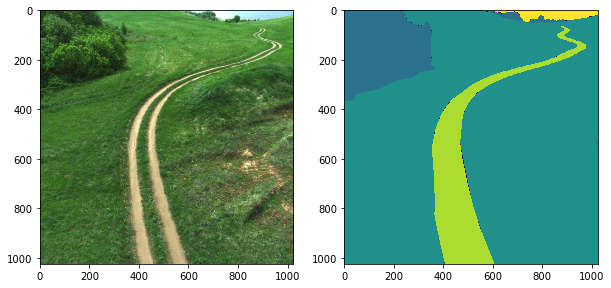

In [9]:
fig, axes = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(10,5)
axes[0].imshow(x[0])
axes[1].imshow(y[0])

# Split images and masks into batches (optional)

In [10]:
h_t, w_t = (512,512)
split_factor = 4 # We crop this number of smaller images out of one
x_t = np.zeros([n_images*split_factor, h_t, w_t, 3], dtype='uint8')
y_t = np.zeros([n_images*split_factor, h_t, w_t], dtype='uint8')

In [11]:
print(x_t.shape)
print(y_t.shape)

(40, 512, 512, 3)
(40, 512, 512)


In [12]:
for i in range(n_images):
    x_t[i] = x[i,:h//2,:w//2,:]
    x_t[n_images+i] = x[i,:h//2,w//2:w,:]
    x_t[n_images*2+i] = x[i,h//2:h,:w//2,:]
    x_t[n_images*3+i] = x[i,h//2:h,w//2:w,:]
    y_t[i] = y[i,:h//2,:w//2]
    y_t[n_images+i] = y[i,:h//2,w//2:w]
    y_t[n_images*2+i] = y[i,h//2:h,:w//2]
    y_t[n_images*3+i] = y[i,h//2:h,w//2:w]

In [13]:
print(x.shape)
print(y.shape)

(10, 1024, 1024, 3)
(10, 1024, 1024)


In [14]:
print(x_t.shape)
print(y_t.shape)

(40, 512, 512, 3)
(40, 512, 512)


In [15]:
x = x_t
y = y_t
del(x_t,y_t)

# Class weighting

In [16]:
n = np.bincount(y.reshape(y.shape[0]*y.shape[1]*y.shape[2]))

In [17]:
print(str(n/n.sum()*100) + " %")

[  2.03657150e-01   0.00000000e+00   0.00000000e+00   1.22642517e+00
   8.87906265e+01   2.34317780e-02   0.00000000e+00   9.63823318e+00
   1.17626190e-01] %


In [18]:
cs = ['background', 'asphalt', 'building', 'forest', 'grass', 'ground', 'roadAsphalt', 'roadGround', 'water']

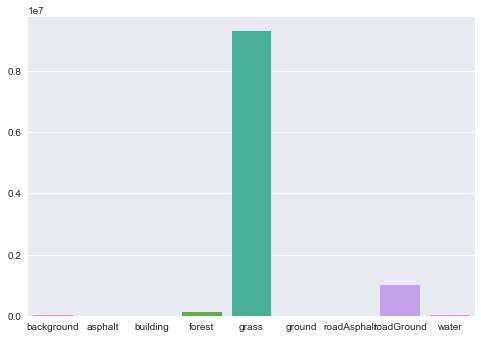

In [19]:
import seaborn as sns

sns.barplot(x=cs, y=n)

In [20]:
cw = np.median(n)/n

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


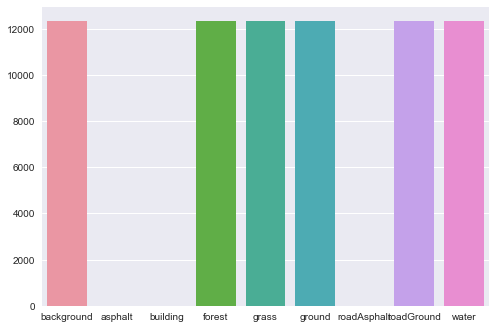

In [21]:
sns.barplot(x=cs, y=n*cw)

In [22]:
class_weights = dict(enumerate(cw))
class_weighting = np.fromiter(class_weights.values(), dtype=float)
class_weighting

array([  5.77569656e-01,              inf,              inf,
         9.59097978e-02,   1.32475910e-03,   5.01994302e+00,
                    inf,   1.22041237e-02,   1.00000000e+00])

In [24]:
n_classes = len(cs)

from keras.utils import to_categorical

y = to_categorical(y, num_classes=n_classes)
y = y.reshape(x.shape[:3] + (n_classes,))
y.shape

(40, 512, 512, 9)

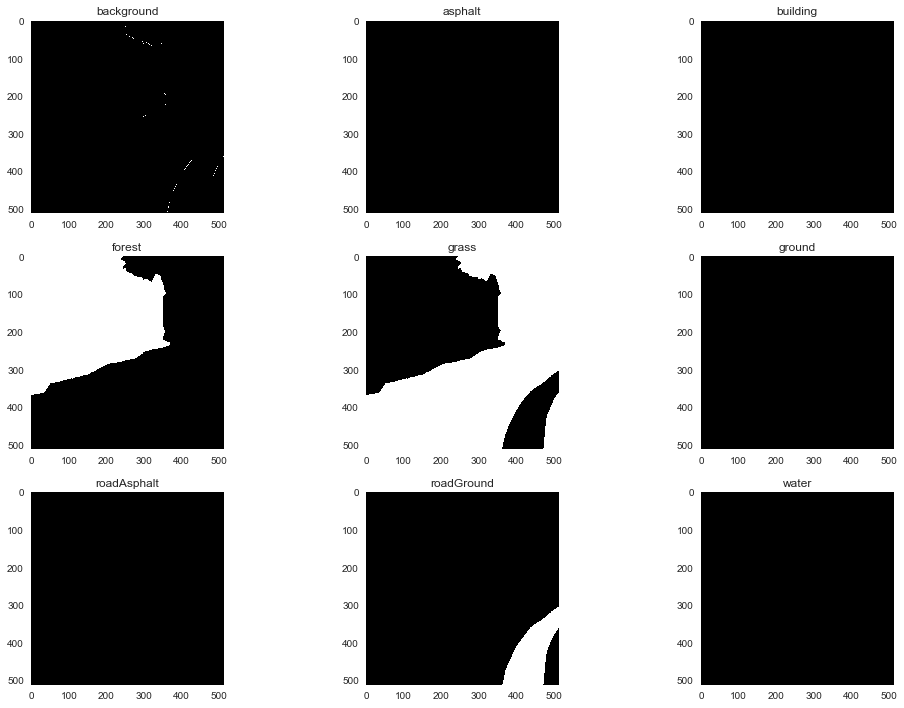

In [25]:
nrows, ncols = 3,3
fig, axes = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(15,10)
cl = 0
im = 0
for i in range(nrows):
    for j in range(ncols):
        axes[i,j].imshow(y[im,:,:,cl], cmap='gray')
        axes[i,j].set_title(cs[cl])
        axes[i,j].grid(None)
        cl += 1
     
fig.tight_layout()

In [ ]:
print(x.dtype)
x = x/255
print(x.dtype)

# Prepare for training

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

del(x,y)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

K.image_data_format()

In [ ]:
nb_train_samples = len(x_train)
nb_test_samples = len(x_test)

In [ ]:
epochs = 1
batch_size = 1

data_gen_args = dict(width_shift_range=0.25,
                     height_shift_range=0.25)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
image_datagen.fit(x_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)

image_generator = image_datagen.flow(x_train, seed=seed, batch_size=batch_size)
mask_generator = mask_datagen.flow(y_train, seed=seed, batch_size=batch_size)

train_generator = zip(image_generator, mask_generator)

test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

# Configure batch size and retrieve one batch of images
# for x_batch in image_datagen.flow(x_train, seed=seed, batch_size=9):
#     # Show 9 images
#     for i in range(0, 9):
#         plt.subplot(330 + 1 + i)
#         plt.imshow(x_batch[i])
#     # show the plot
#     plt.show()
#     break
    
# for y_batch in mask_datagen.flow(y_train, seed=seed, batch_size=9):
#     # Show 9 images
#     for i in range(0, 9):
#         plt.subplot(330 + 1 + i)
#         plt.imshow(y_batch[i,:,:,6])
#     # show the plot
#     plt.show()
#     break

# for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
#     # Show 9 images
#     for i in range(0, 9):
#         plt.subplot(330 + 1 + i)
#         plt.imshow(y_batch[i])
#     # show the plot
#     plt.show()
#     break

In [ ]:
from models.Unet import unet

model = unet(input_size = x_train.shape[1:], n_classes=n_classes)

model.summary()

In [ ]:
from keras import optimizers

#model.compile(optimizer = 'adadelta', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
def get_tf_session():
    gpu_options = tf.GPUOptions(allow_growth=True)
    return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(get_tf_session())

In [ ]:
from keras import callbacks

model_checkpoint = callbacks.ModelCheckpoint('weights/some_name.hdf5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
tensor_board = callbacks.TensorBoard(log_dir='./tblogs')
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, verbose = 1, min_lr=1e-5)
csv_logger = callbacks.CSVLogger('training.log')

In [ ]:
history = model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch=len(x_train)//batch_size,
    validation_steps = len(x_test)//batch_size,
    epochs=epochs,
    verbose = 1,
    class_weight = class_weighting,
    callbacks = [model_checkpoint, tensor_board, reduce_lr, csv_logger]
)